## Event Detection

We expect that as something happens, individuals will tweet about it in real-time causing bursts in Twitter activity. Within our event timeline, we can identify specific areas of importance for summarization in this way. We can call these subevents.

**Measurment:** We define our measure as volume of tweets per minute, and an anomoly in this frequency would indicate a subevent.

**Method:** Anomalies are then detected by measuring the deviation from an expected frequency. Expected frequency is calculated using simple moving average using a window of 5 minutes, otherwise known as rolling mean. The intensity of the subevent is then measured as the deviation from the expected, and can be used to set a dynamic threshold for summarizing those which are most significant.

$expected = \frac{1}{n} \sum_{i=0}^{n-1} y-i$

Simple outlier detection algorithms look at values greated than a number of standard deviations from mean. Since we are limited to summarizing only that data which we can communicate we set a fixed threshold.

Subevents are considered for summarization if $y_{i} - expected > threshold$ where *threshold* is dynamically computed to include top *k* number of subevents.

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import pairwise_distances

In [3]:
df = pd.read_csv('data/final/event_EgyptAirFlight804_data.txt', sep='\t', encoding='utf-8', header=0, low_memory=False, parse_dates=['created_at'])
df.shape

(59575, 35)

### rolling mean

In [4]:
#d = df.set_index('created_at').groupby([pd.TimeGrouper(freq='T')])['twitter_id'].agg(['count'])
# zoom in range to better visualize
dfslice = df.set_index('created_at')['2016-05-18 23':'2016-05-19 12']
d = dfslice.groupby([pd.TimeGrouper(freq='T')])['twitter_id'].agg(['count'])
timeframe = pd.date_range(d.index.min(), d.index.max(), freq='T')
d = d.reindex(timeframe, fill_value=0)

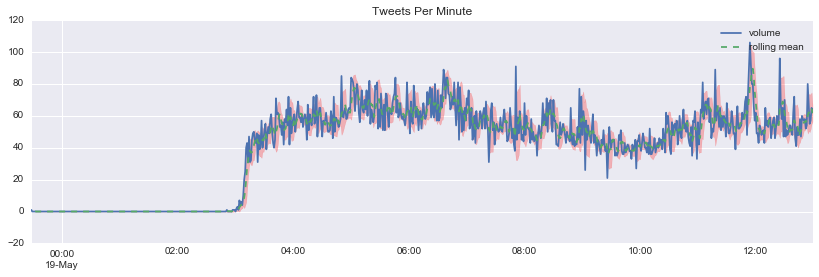

In [5]:
d['mean'] = d['count'].rolling(window=5).agg(['mean'])
d['std'] = d['count'].rolling(window=5).agg(['std'])

plt.title('Tweets Per Minute')
ax = d['count'].plot(figsize=(14,4), label='volume')
d['mean'].plot(ax=ax, style='--', label='rolling mean')
ax.fill_between(d.index, d['mean'] - d['std'], d['mean'] + d['std'], alpha=.25, color='r')
plt.legend()

### mean deviation

#### outside bounds of +1 standard deviation

In [6]:
d['deviation'] = d['count'] - d['mean']

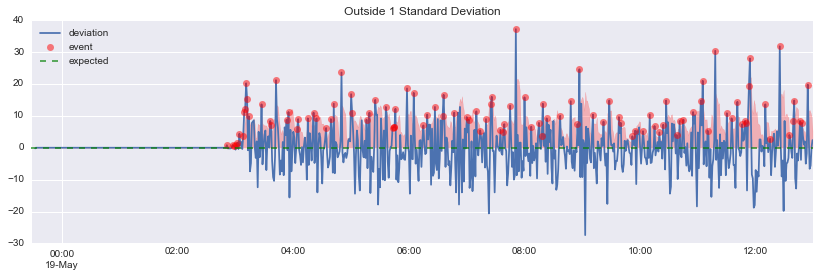

In [7]:
plt.title('Outside 1 Standard Deviation')
ax = d['deviation'].plot(figsize=(14,4), label='deviation')
d[d['count'] > (d['mean'] + d['std'])]['deviation'].plot(ax=ax, style='ro', alpha=.50, label='event')
ax.axhline(y=0, linestyle='--', color='g', alpha=.70, label='expected')
ax.fill_between(d.index, 0, 0 + d['std'], alpha=.25, color='r')
plt.legend(loc='best')

#### top k devianions from rolling mean

In [10]:
k = 10
threshold = d[d['deviation']>0]['deviation'].sort_values(ascending=False).iloc[:k].min()

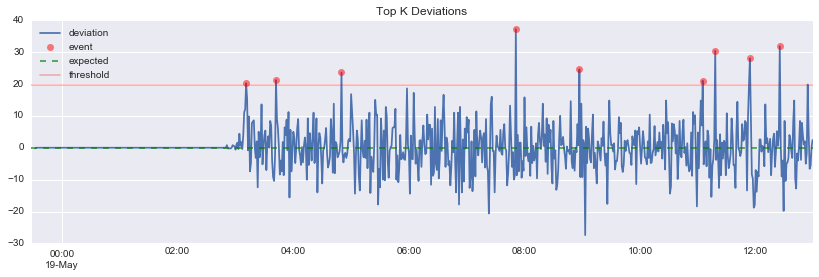

In [11]:
plt.title('Top K Deviations')
ax = d['deviation'].plot(figsize=(14,4), label='deviation')
d[d['deviation'] > threshold]['deviation'].plot(ax=ax, style='ro', alpha=.50, label='event')
ax.axhline(y=0, linestyle='--', color='g', alpha=.70, label='expected')
ax.axhline(y=threshold, linestyle='-', color='r', alpha=.25, label='threshold')
plt.legend(loc='best')

#### get events

In [12]:
event_times = d[d['deviation'] > threshold].index
event_times = pd.DataFrame(event_times, columns=['created_at'])

df['created_at'] = df['created_at'].apply(lambda d: d.replace(second=0))
events = df.merge(event_times, how='inner', on='created_at')

In [19]:
events.groupby('created_at').size()

created_at
2016-05-19 03:11:00     40
2016-05-19 03:42:00     71
2016-05-19 04:50:00     85
2016-05-19 07:51:00     91
2016-05-19 08:57:00     77
2016-05-19 11:05:00     81
2016-05-19 11:18:00     89
2016-05-19 11:54:00    106
2016-05-19 12:25:00     96
dtype: int64

#### highest rated tweet using top terms

In [224]:
for t in events['created_at'].unique():
    event = events[events['created_at'] == t]
    
    tweets = [ str(t) for t in event['text']]
    tokens = [ w for t in tweets for w in t.split()]
    k = 20
    topk_terms = pd.DataFrame(tokens, columns=['tokens'])['tokens'].value_counts(normalize=True)[:k]
    #topk_terms.sort_values(ascending=True).plot(kind='barh', title='Top Terms')
    event['topk_terms_coverage'] = event['text'].apply(lambda text: len([token for token in text.split() if token.lower() in topk_terms]) / len(topk_terms))
    print(pd.to_datetime(t), event.sort_values(by='topk_terms_coverage', ascending=False)['text'].iloc[0])

2016-05-19 03:11:00 #BREAKING NEWS: @cnn is reporting an #EgyptAir flight heading from Paris to Cairo has disappeared from the radar.
2016-05-19 03:42:00 cnnbrk: #EgyptAir now says the flight from Paris to Cairo disappeared shortly after entering Egyptian airspace. https://t.co/hnn2ghbu4X
2016-05-19 04:50:00 My thoughts and prayers are with the loved ones of those on board the missing #EgyptAir flight.
2016-05-19 07:51:00 #rawnaija_gist #EgyptAir: @EGYPTAIR - Flight MS804 From Paris To Cairo Disappears.: Egyp... https://t.co/da5KW6H05O / via @rawnaija_gist
2016-05-19 08:57:00 #EgyptAir flight with Briton among 66 on board 'crashed near Greek Med island' - Read more: https://t.co/UwdjpB425N https://t.co/9ftzElm2RV
2016-05-19 11:05:00 #news Airbus A320, the model of #EgyptAir plane that crashed, is the workhorse of the skies, AP reports
2016-05-19 11:18:00 #EgyptAir #plane with Briton among passengers 'crashes near Greek island in Med' - https://t.co/rH9vtEv7OJ https://t.co/UijsaJurrY
20

c:\miniconda3\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### centroid method

In [175]:
#count_vectorizer = CountVectorizer(stop_words='english', vocabulary=None)
#X = count_vectorizer.fit_transform(event['text'])
#terms = pd.DataFrame(count_vectorizer.get_feature_names(), columns=['term'])
#initialize centroid of zeros
#centroid = np.zeros([X.shape[1],1])
#fill 1 at top terms indices
#centroid[list(terms[terms['term'].isin(topk.index)].index)] = 1
#compute pairwise distance for each doc to centroid using cosine similarity equation
#X_centroid_cosdistance = pairwise_distances(X=X, Y=centroid, metric='cosine')

#### first at time

In [32]:
event_times = d[d['deviation'] > threshold].index
event_times = pd.DataFrame(event_times, columns=['created_at'])

df['created_at'] = df['created_at'].apply(lambda d: d.replace(second=0))
events = df.merge(event_times, how='inner', on='created_at')

for time, text in events.groupby('created_at').nth([0])['text'].iteritems():
    print(time, text)

2016-05-19 03:11:00 #EgyptAir flight might be missing? I hope not... .. :/
2016-05-19 03:12:00 BREAKING NEWS: @EGYPTAIR flight goes off radar en route from Paris.   #EgyptAir
2016-05-19 03:42:00 #EgyptAir Flight #MS804 from Paris to Cairo 'disappears from radar' https://t.co/GUq0ZSZy7P
2016-05-19 04:50:00 Prayers go out to friends and families of the victims of  #EgyptAir
2016-05-19 05:00:00 Just awoke to hear the news on #EgyptAir  Hoping for a good outcome
2016-05-19 05:25:00 Praying for their survival! #EgyptAir flight MS804 disappears from radar between Paris and Cairo – live updates https://t.co/rxirA1Jid6
2016-05-19 05:58:00 THEY DIDNT CALL FOR HELP OR ANYTHING THIS IS TOO WEIRD OMYGOD 😓  #EgyptAir
2016-05-19 06:05:00 Why are people fussy about nationalities of those on board #EgyptAir seriously it doesn't matter we are all humans aren't we????
2016-05-19 06:36:00 Another plane gone missing. :( I sincerely hope we find #EgyptAir ❤️❤️❤️
2016-05-19 07:26:00 Thoughts are with those 